In [1]:
!pip install visualkeras seaborn

In [2]:
import os

DISABLE_GPU = True
if DISABLE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random

from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import visualkeras

In [4]:
import h5py

In [5]:
tf.keras.backend.clear_session()

In [6]:
train_path = '../data/Coivd-19_Synthetic/GANGEN_2022-6-30-05-53_v5'
test_path = '../data/Covid-19 Image Dataset/test'

In [7]:
labels = os.listdir(train_path)
print(labels)

['Covid', 'Normal', 'Viral Pneumonia']


In [8]:
def load_random_imgs_from_folder(folder,label):
    plt.figure(figsize=(15,15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,3,i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img)

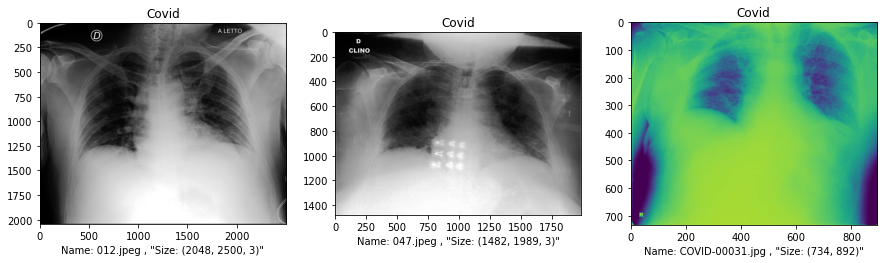

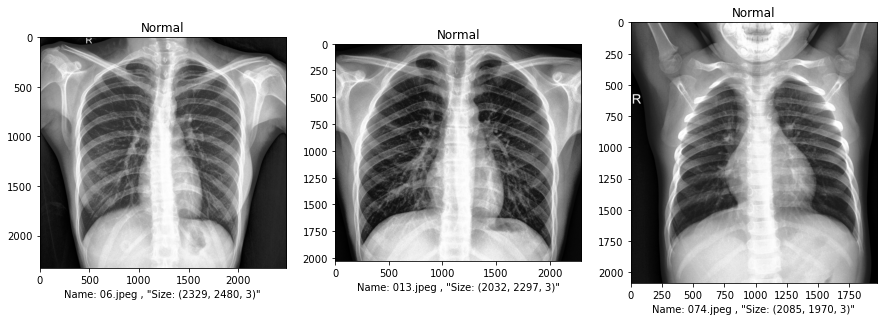

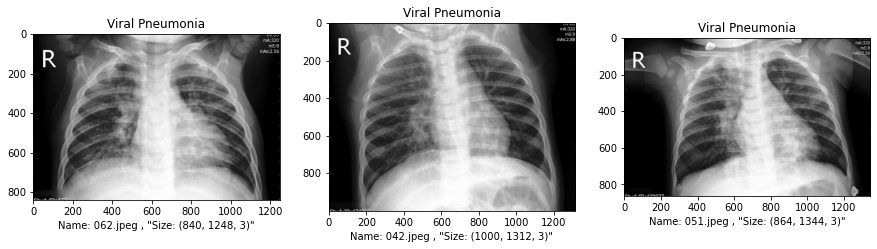

In [9]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 0.5,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [11]:
img_size = 128
batch = 16
train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    batch_size=batch,
                                                    class_mode="categorical",
                                                    target_size=(img_size,img_size)
                                                    )
test_generator = test_val_datagen.flow_from_directory(directory=test_path,
                                                    batch_size=1,
                                                    shuffle=False,
                                                    class_mode="categorical",
                                                    target_size=(img_size,img_size)
                                                    )

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [12]:
model = Sequential()
model.add(Conv2D(filters=16, input_shape=(img_size,img_size,3), kernel_size=(9,9), strides=(5,5), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'))
model.add(BatchNormalization())
# model.add(Dropout(0.2)) # 2022年6月30日06点07分 avoid underfitting

# Passing it to a dense layer
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
# model.add(Dropout(0.5)) # original
model.add(Dropout(0.3)) # 2022年6月30日06点07分 avoid underfitting
model.add(BatchNormalization())
# output Layer 
model.add(Dense(len(labels)))
model.add(Activation('softmax'))

In [13]:
# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [14]:
!pip install pydot

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 16)        3904      
                                                                 
 activation (Activation)     (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 12, 12, 32)        0

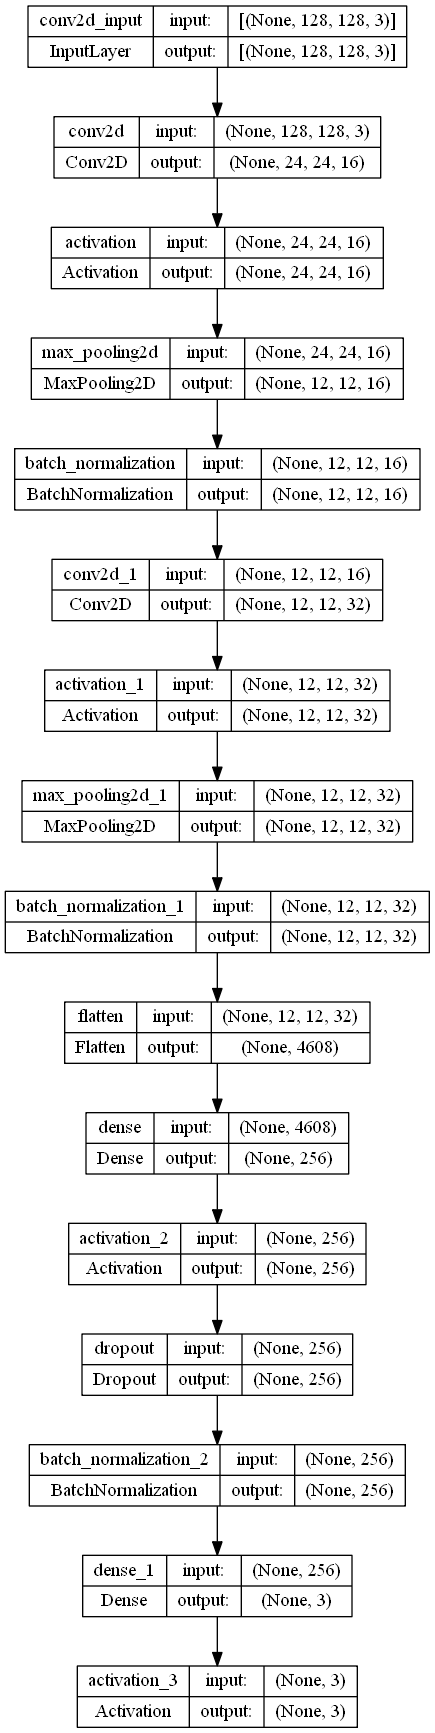

In [16]:
plot_model(model, to_file='../images/alex_model.png', show_shapes=True, show_layer_names=True)

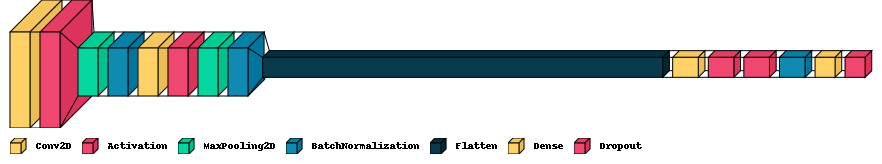

In [17]:
visualkeras.layered_view(model, legend=True)

In [18]:
# callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1), 
#              ModelCheckpoint('../models/mlp_model_cacgan.h5', save_best_only=True)]
callbacks = [EarlyStopping(monitor='val_accuracy', patience=100, verbose=1), 
             ModelCheckpoint('../models/alex_model.h5', save_best_only=True)] # for future training 2022年6月30日06点35分

In [19]:
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
history = model.fit(train_generator,
                    epochs=320,
                    validation_data=test_generator,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/320
16/16 [==============================] - 7s 443ms/step - loss: 0.7718 - accuracy: 0.7171 - val_loss: 1.1694 - val_accuracy: 0.3485
Epoch 2/320
16/16 [==============================] - 7s 435ms/step - loss: 0.5860 - accuracy: 0.7689 - val_loss: 0.7798 - val_accuracy: 0.6061
Epoch 3/320
16/16 [==============================] - 7s 430ms/step - loss: 0.5340 - accuracy: 0.8008 - val_loss: 0.7832 - val_accuracy: 0.6667
Epoch 4/320
16/16 [==============================] - 7s 431ms/step - loss: 0.4634 - accuracy: 0.8367 - val_loss: 0.9091 - val_accuracy: 0.4394
Epoch 5/320
16/16 [==============================] - 7s 439ms/step - loss: 0.3931 - accuracy: 0.8367 - val_loss: 1.0178 - val_accuracy: 0.4545
Epoch 6/320
16/16 [==============================] - 7s 445ms/step - loss: 0.4015 - accuracy: 0.8247 - val_loss: 0.8682 - val_accuracy: 0.5152
Epoch 7/320
16/16 [==============================] - 7s 440ms/step - loss: 0.3917 - accuracy: 0.8486 - val_loss: 0.8082 - val_accuracy: 0.5758

Epoch 58/320
16/16 [==============================] - 7s 441ms/step - loss: 0.2269 - accuracy: 0.9203 - val_loss: 0.8670 - val_accuracy: 0.7121
Epoch 59/320
16/16 [==============================] - 7s 429ms/step - loss: 0.2562 - accuracy: 0.8845 - val_loss: 0.2979 - val_accuracy: 0.9091
Epoch 60/320
16/16 [==============================] - 7s 442ms/step - loss: 0.2177 - accuracy: 0.9203 - val_loss: 0.2573 - val_accuracy: 0.8485
Epoch 61/320
16/16 [==============================] - 7s 442ms/step - loss: 0.2691 - accuracy: 0.8884 - val_loss: 0.2873 - val_accuracy: 0.8939
Epoch 62/320
16/16 [==============================] - 7s 440ms/step - loss: 0.3018 - accuracy: 0.9044 - val_loss: 0.8451 - val_accuracy: 0.6515
Epoch 63/320
16/16 [==============================] - 9s 562ms/step - loss: 0.2614 - accuracy: 0.8964 - val_loss: 0.5280 - val_accuracy: 0.8333
Epoch 64/320
16/16 [==============================] - 7s 433ms/step - loss: 0.2258 - accuracy: 0.9203 - val_loss: 0.3362 - val_accuracy:

Epoch 115/320
16/16 [==============================] - 7s 422ms/step - loss: 0.2011 - accuracy: 0.9283 - val_loss: 0.8960 - val_accuracy: 0.8182
Epoch 116/320
16/16 [==============================] - 7s 438ms/step - loss: 0.2074 - accuracy: 0.9283 - val_loss: 0.6405 - val_accuracy: 0.8939
Epoch 117/320
16/16 [==============================] - 7s 428ms/step - loss: 0.2122 - accuracy: 0.9124 - val_loss: 0.4787 - val_accuracy: 0.8939
Epoch 118/320
16/16 [==============================] - 7s 433ms/step - loss: 0.1817 - accuracy: 0.9243 - val_loss: 1.3540 - val_accuracy: 0.6818
Epoch 119/320
16/16 [==============================] - 7s 426ms/step - loss: 0.1750 - accuracy: 0.9402 - val_loss: 0.6775 - val_accuracy: 0.7879
Epoch 120/320
16/16 [==============================] - 7s 426ms/step - loss: 0.2529 - accuracy: 0.9084 - val_loss: 0.3106 - val_accuracy: 0.9091
Epoch 121/320
16/16 [==============================] - 7s 433ms/step - loss: 0.2095 - accuracy: 0.9163 - val_loss: 0.2850 - val_ac

16/16 [==============================] - 7s 433ms/step - loss: 0.2190 - accuracy: 0.9163 - val_loss: 0.0837 - val_accuracy: 0.9545
Epoch 172/320
16/16 [==============================] - 7s 431ms/step - loss: 0.1794 - accuracy: 0.9402 - val_loss: 0.1162 - val_accuracy: 0.9394
Epoch 173/320
16/16 [==============================] - 7s 436ms/step - loss: 0.1213 - accuracy: 0.9761 - val_loss: 0.1358 - val_accuracy: 0.9545
Epoch 174/320
16/16 [==============================] - 7s 430ms/step - loss: 0.2224 - accuracy: 0.9243 - val_loss: 0.1090 - val_accuracy: 0.9545
Epoch 175/320
16/16 [==============================] - 7s 432ms/step - loss: 0.1533 - accuracy: 0.9402 - val_loss: 0.0980 - val_accuracy: 0.9545
Epoch 176/320
16/16 [==============================] - 7s 429ms/step - loss: 0.1194 - accuracy: 0.9522 - val_loss: 0.0964 - val_accuracy: 0.9545
Epoch 177/320
16/16 [==============================] - 7s 441ms/step - loss: 0.1766 - accuracy: 0.9402 - val_loss: 0.1330 - val_accuracy: 0.9242

16/16 [==============================] - 7s 429ms/step - loss: 0.1218 - accuracy: 0.9602 - val_loss: 0.1319 - val_accuracy: 0.9545
Epoch 228/320
16/16 [==============================] - 7s 433ms/step - loss: 0.1401 - accuracy: 0.9522 - val_loss: 0.3526 - val_accuracy: 0.8636
Epoch 229/320
16/16 [==============================] - 7s 430ms/step - loss: 0.1290 - accuracy: 0.9442 - val_loss: 0.6858 - val_accuracy: 0.7879
Epoch 230/320
16/16 [==============================] - 7s 423ms/step - loss: 0.1321 - accuracy: 0.9482 - val_loss: 0.3418 - val_accuracy: 0.8636
Epoch 231/320
16/16 [==============================] - 7s 433ms/step - loss: 0.1501 - accuracy: 0.9402 - val_loss: 0.1698 - val_accuracy: 0.9394
Epoch 232/320
16/16 [==============================] - 7s 436ms/step - loss: 0.1293 - accuracy: 0.9522 - val_loss: 0.1195 - val_accuracy: 0.9242
Epoch 233/320
16/16 [==============================] - 7s 433ms/step - loss: 0.1071 - accuracy: 0.9562 - val_loss: 0.1600 - val_accuracy: 0.9091

16/16 [==============================] - 7s 429ms/step - loss: 0.1061 - accuracy: 0.9562 - val_loss: 0.1138 - val_accuracy: 0.9545
Epoch 284/320
16/16 [==============================] - 7s 432ms/step - loss: 0.1631 - accuracy: 0.9402 - val_loss: 0.2216 - val_accuracy: 0.8939
Epoch 285/320
16/16 [==============================] - 7s 439ms/step - loss: 0.1052 - accuracy: 0.9641 - val_loss: 0.1525 - val_accuracy: 0.9545
Epoch 286/320
16/16 [==============================] - 7s 428ms/step - loss: 0.1622 - accuracy: 0.9323 - val_loss: 0.3049 - val_accuracy: 0.8788
Epoch 287/320
16/16 [==============================] - 7s 433ms/step - loss: 0.1732 - accuracy: 0.9562 - val_loss: 0.4794 - val_accuracy: 0.7879
Epoch 288/320
16/16 [==============================] - 7s 440ms/step - loss: 0.1135 - accuracy: 0.9522 - val_loss: 0.8512 - val_accuracy: 0.6970
Epoch 289/320
16/16 [==============================] - 7s 434ms/step - loss: 0.2062 - accuracy: 0.9243 - val_loss: 0.1381 - val_accuracy: 0.9545

In [21]:
model = load_model('../models/alex_model.h5')

In [22]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_ylim(bottom=0.0, top=3.0)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

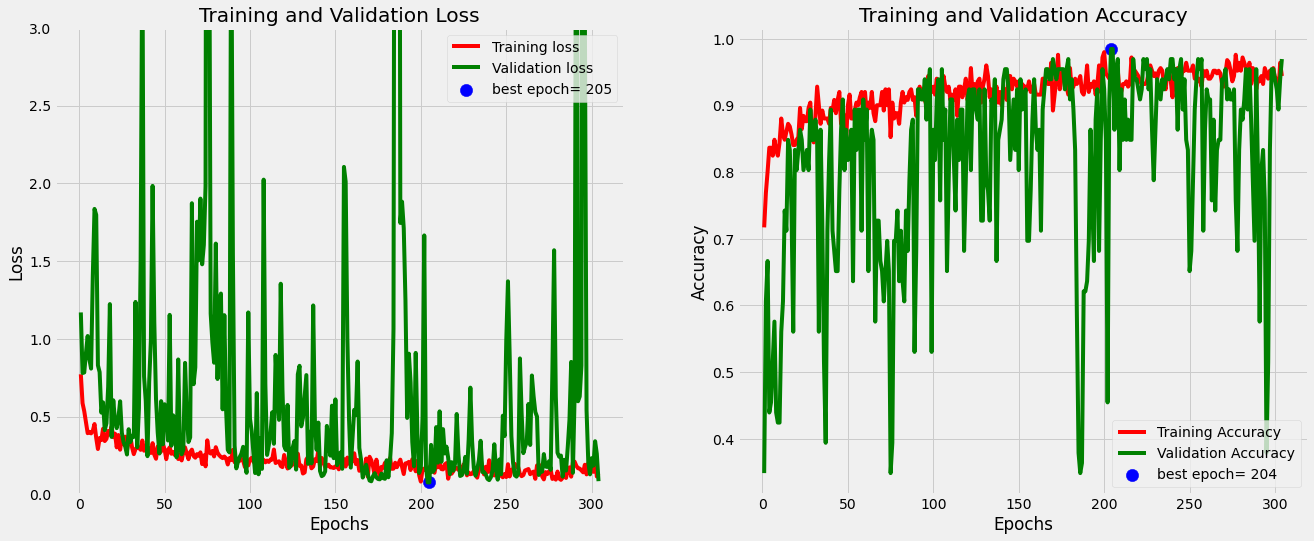

In [23]:
tr_plot(history, 0)

In [24]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

66/66 [==============================] - 1s 13ms/step - loss: 0.0761 - accuracy: 0.9848
Loss: 7.607
Accuracy: 98.485


In [25]:
predictions = np.argmax(model.predict(test_generator),axis=1)
labels = test_generator.classes
predictions , labels

66/66 [==============================] - 3s 14ms/step


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [26]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta_squared = 4

    y_pred = K.clip(y_pred, 0, 1)
 
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [27]:
def confusion_matrix_plot(matrix):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    plt.savefig('../images/con_mat_cacgan.png')
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); 
    ax.yaxis.set_ticklabels(classes[::-1]);
    plt.show()

In [28]:
def cal_score(model, plot=True):
    matrix = confusion_matrix(predictions, labels)
    print(matrix)
    print('\n')

    f1 = f1_score(predictions, labels, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(predictions, labels, target_names=classes))
    
    if plot:
        confusion_matrix_plot(matrix)

In [29]:
classes = []
for i in os.listdir(test_path):
    classes += [i]

print(classes)

['Covid', 'Normal', 'Viral Pneumonia']


[[26  0  1]
 [ 0 20  0]
 [ 0  0 19]]


F1 Score: 0.9848997962205509


                 precision    recall  f1-score   support

          Covid       1.00      0.96      0.98        27
         Normal       1.00      1.00      1.00        20
Viral Pneumonia       0.95      1.00      0.97        19

       accuracy                           0.98        66
      macro avg       0.98      0.99      0.99        66
   weighted avg       0.99      0.98      0.98        66



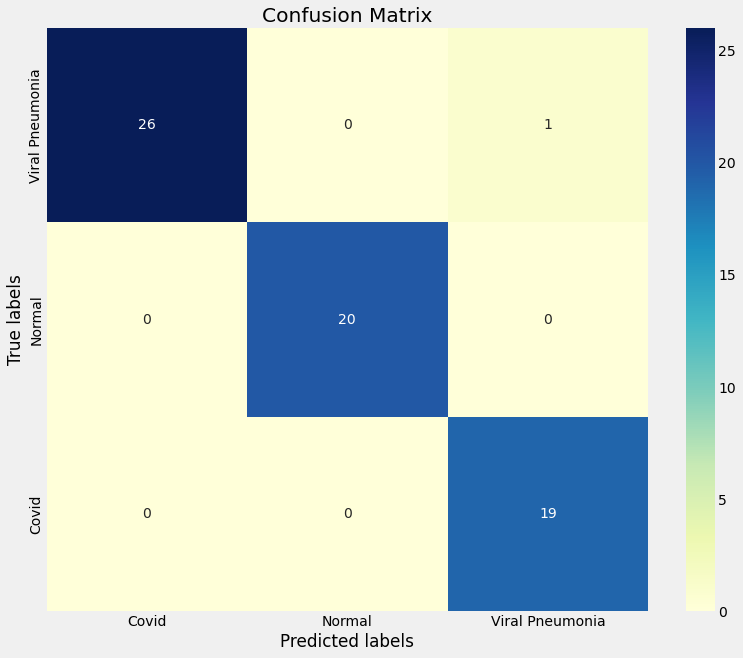

In [30]:
cal_score(model, plot=True)